In [42]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

from keras.layers import Dense, SimpleRNN, GRU
from keras.optimizers import SGD

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [43]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [44]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [45]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [46]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()


In [47]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [48]:
def DP_LSTM(company, df):
  # Adding noise to dataset
  # calculating the variance of the mean_compound column
  news_column  = 'mean_compound'
  mc_var=np.var(df.mean_compound)
  mu=0
  noise=0.1
  sigma_noise = noise*mc_var
  n = df.shape[0]
  # create a dataframe for noise
  df_noise = pd.DataFrame()
  df_noise['mc_noise'] = df[news_column]
  for i in range(0,n):
      df_noise['mc_noise'][i]+=np.random.normal(mu,sigma_noise)  
  noise_name = "mc_noise_"+company+".csv"    
  df_noise.to_csv(noise_name)
  dfn = pd.read_csv(noise_name,index_col=0)
  # creating one dataframe by adding noise in news columns 
  df1 = pd.DataFrame()
  df1['price'] = df['adj_close']
  df1['mc'] = dfn['mc_noise']
  # creating another dataframe by adding normal noise column 
  df2 = pd.DataFrame()
  df2['price'] = df['adj_close']
  df2['mc'] = df['mean_compound']

  # choosing columns for the model
  cols = ['price','mc']
  # deciding the split size
  split = 0.85
  sequence_length=10;
  split_index = int(len(df1) * split)
  data_train1 = df1.get(cols).values[:split_index]
  data_train2 = df2.get(cols).values[:split_index]
  train_len  = len(data_train1)
  train_windows_len = None

  # Normalizing Train data1
  data_windows1 = create_windows(data_train1,train_len,sequence_length)
  normalized_data1,rmax_t1, rmin_t1 = Normalize_data(data_windows1)

  x_train1 = normalized_data1[:, :-1]
  y_train1 = normalized_data1[:, -1,[0]]

  # Normalizing Train data2
  data_windows2 = create_windows(data_train2, train_len,sequence_length)
  normalized_data2,rmax_t2, rmin_t2 = Normalize_data(data_windows2)

  x_train2 = normalized_data2[:, :-1]
  y_train2 = normalized_data2[:, -1,[0]]

  # concatenating the training data
  x_train = np.concatenate((x_train1,x_train2),axis=0)
  y_train = np.concatenate((y_train1,y_train2),axis=0)
  x_train.shape, y_train.shape

  #x_train = x_train1
  #y_train = y_train1

  # Creating the Test Data
  df_test = pd.read_csv(df_name, index_col = 0)
  df_test = df_test.rename(columns = {'adj_close': 'price','mean_compound':'mc'})
  #df_test['date'] = pd.to_datetime(df_test['date'])
  cols = ['price','mc']
  cols2 = ['date']
  test_len = df_test.shape[0]

  data_test  = df_test.get(cols).values[split_index:]
  data_test2  = df_test.get(cols2).values[split_index:]

  data_windows_test = create_windows(data_test, len(data_test), sequence_length)
  # the last price value of each window is the original y_test
  y_test_original = data_windows_test[:, -1, [0]]

  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  
  
  # Setting the parameters  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9

  # Simple RNN model
  model = Sequential()
  model.add(SimpleRNN(units = 60, activation = 'relu',return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 60,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 80, activation = 'relu',return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = 120,activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=50, batch_size=32)
  

  plot_training_loss(hist)
  #model_name = company+'_stock_predict_LSTM' 
  #model.save('saved_model/'+model_name)
  # Loading the model
  #model = tf.keras.models.load_model('saved_model/stock_predict_LSTM')

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)
  print(len(predicted_vals))
  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)

  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")
  
  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [49]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
Epoch 1/50
141/141 [==============================] - 6s 14ms/step - loss: 0.2042 - mean_squared_error: 0.2042
Epoch 2/50
141/141 [==============================] - 2s 14ms/step - loss: 0.0952 - mean_squared_error: 0.0952
Epoch 3/50
141/141 [==============================] - 2s 15ms/step - loss: 0.0851 - mean_squared_error: 0.0851
Epoch 4/50
141/141 [==============================] - 2s 15ms/step - loss: 0.0843 - mean_squared_error: 0.0843
Epoch 5/50
141/141 [==============================] - 2s 14ms/step - loss: 0.0807 - mean_squared_error: 0.0807
Epoch 6/50
141/141 [==============================] - 2s 14ms/step - loss: 0.0773 - mean_squared_error: 0.0773
Epoch 7/50
141/141 [==============================] - 2s 14ms/step - loss: 0.0775 - mean_squared_error: 0.0775
Epoch 8/50
141/141 [==============================] - 2s 14ms/step - loss: 0.0737 - mean_squared_error: 0.0737
Epoch 9/50
141/141 [==============================] - 2s 14ms/step - loss: 0

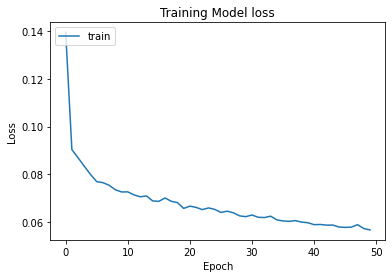

390
           date     Actual    Predicted
0    2018-07-27  47.023903  [46.899063]
1    2018-07-30  46.241833  [46.913475]
2    2018-07-31  45.982750  [46.828773]
3    2018-08-01  46.074760   [46.89897]
4    2018-08-02  48.789028   [48.06358]
..          ...        ...          ...
385  2020-02-07  80.486107   [78.27793]
386  2020-02-10  79.392090  [79.611664]
387  2020-02-11  79.769165   [78.45712]
388  2020-02-12  79.287888   [77.71588]
389  2020-02-13  81.170799   [78.06386]

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0754 - mean_squared_error: 0.0754
LSTM Model Loss =  [0.07538937032222748, 0.07538937032222748]
Model Accuracy =  [98.445564]
Mean Absolute Error =  0.7844048720139727  degrees
Mean Squared Error =  0.947311598313704
Root Mean Squared Error =  0.9732993364395683

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
Epoch 1/50
141/141

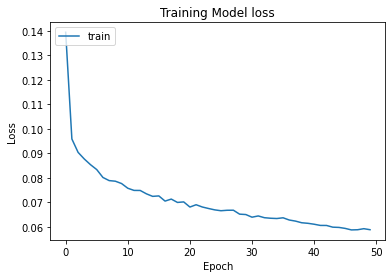

390
           date       Actual    Predicted
0    2018-07-27  1808.000000  [1848.1577]
1    2018-07-30  1817.270020  [1843.6481]
2    2018-07-31  1779.219971  [1813.7965]
3    2018-08-01  1777.439941  [1812.8971]
4    2018-08-02  1797.170044  [1825.4519]
..          ...          ...          ...
385  2020-02-07  2050.229980  [1998.2136]
386  2020-02-10  2079.280029   [2019.823]
387  2020-02-11  2133.909912  [2068.7837]
388  2020-02-12  2150.800049  [2079.8953]
389  2020-02-13  2160.000000  [2092.7312]

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0788 - mean_squared_error: 0.0788
LSTM Model Loss =  [0.07879787683486938, 0.07879787683486938]
Model Accuracy =  [98.220695]
Mean Absolute Error =  31.05294439853766  degrees
Mean Squared Error =  1732.4961035585175
Root Mean Squared Error =  41.62326397050714

--------------------------------------------------------------------------

Evaluating Model for Company:  

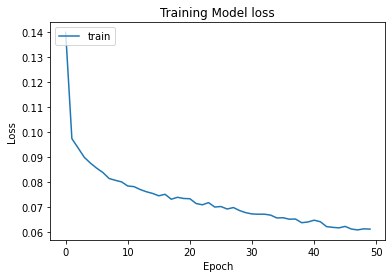

390
           date     Actual    Predicted
0    2018-07-27  43.653885  [43.348537]
1    2018-07-30  43.562386  [43.496815]
2    2018-07-31  43.324490   [43.30226]
3    2018-08-01  44.157127  [43.865158]
4    2018-08-02  44.019875  [43.833847]
..          ...        ...          ...
385  2020-02-07  44.165833  [43.538586]
386  2020-02-10  43.906483  [43.710754]
387  2020-02-11  43.877670  [43.595776]
388  2020-02-12  44.300312  [43.782642]
389  2020-02-13  44.155090    [43.5329]

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0742 - mean_squared_error: 0.0742
LSTM Model Loss =  [0.07421499490737915, 0.07421499490737915]
Model Accuracy =  [98.80026]
Mean Absolute Error =  0.48576085017277654  degrees
Mean Squared Error =  0.362796329062071
Root Mean Squared Error =  0.6023257665599828

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
Epoch 1/50
141/141

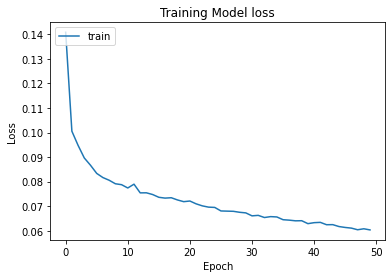

390
           date       Actual    Predicted
0    2018-07-27  1268.329956  [1251.3772]
1    2018-07-30  1238.500000  [1250.5072]
2    2018-07-31  1219.739990  [1247.2335]
3    2018-08-01  1217.260010  [1247.8068]
4    2018-08-02  1220.010010  [1250.9489]
..          ...          ...          ...
385  2020-02-07  1476.229980  [1462.1761]
386  2020-02-10  1479.229980  [1475.3336]
387  2020-02-11  1508.680054  [1484.3973]
388  2020-02-12  1508.790039  [1481.9126]
389  2020-02-13  1518.270020   [1490.041]

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0934 - mean_squared_error: 0.0934
LSTM Model Loss =  [0.09338309615850449, 0.09338309615850449]
Model Accuracy =  [98.54199]
Mean Absolute Error =  16.998612780448724  degrees
Mean Squared Error =  450.4441892109049
Root Mean Squared Error =  21.22367049336436

--------------------------------------------------------------------------

Evaluating Model for Company:  E

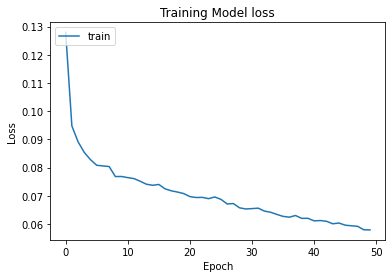

390
           date     Actual    Predicted
0    2018-07-27  33.331360  [33.797066]
1    2018-07-30  32.731140  [33.788506]
2    2018-07-31  32.595608  [33.781933]
3    2018-08-01  32.382629  [33.719036]
4    2018-08-02  32.034122  [32.479607]
..          ...        ...          ...
385  2020-02-07  37.343075  [35.692837]
386  2020-02-10  35.574196  [35.379547]
387  2020-02-11  35.397308  [35.056717]
388  2020-02-12  35.810051   [35.93613]
389  2020-02-13  36.507778   [35.83799]

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0722 - mean_squared_error: 0.0722
LSTM Model Loss =  [0.07224177569150925, 0.07224177569150925]
Model Accuracy =  [98.56877]
Mean Absolute Error =  0.478487401130872  degrees
Mean Squared Error =  0.3656158020580617
Root Mean Squared Error =  0.6046617253126426

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
Epoch 1/50
141/141 [

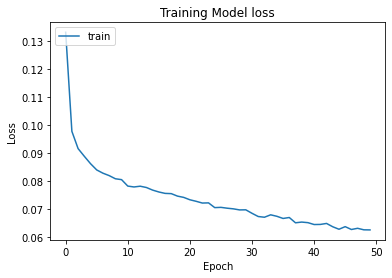

390
           date     Actual    Predicted
0    2018-07-27  71.726852   [70.24772]
1    2018-07-30  69.751480  [70.764984]
2    2018-07-31  69.598213   [70.84829]
3    2018-08-01  69.402374   [70.88707]
4    2018-08-02  68.448746   [70.34555]
..          ...        ...          ...
385  2020-02-07  56.346684  [56.390793]
386  2020-02-10  55.973351  [55.963516]
387  2020-02-11  55.382210  [55.973984]
388  2020-02-12  55.908691  [56.036793]
389  2020-02-13  56.592194  [55.958805]

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.0783 - mean_squared_error: 0.0783
LSTM Model Loss =  [0.07830964028835297, 0.07830964028835297]
Model Accuracy =  [98.73614]
Mean Absolute Error =  0.8288095034085791  degrees
Mean Squared Error =  1.0844932511357448
Root Mean Squared Error =  1.0413900571523356

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
Epoch 1/50
141/141 

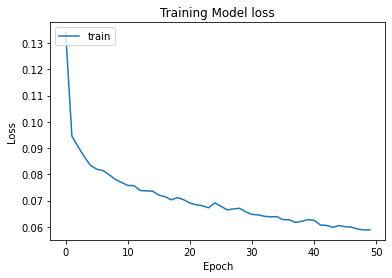

390
           date     Actual    Predicted
0    2018-07-27  63.071827  [61.849636]
1    2018-07-30  62.687599  [62.210667]
2    2018-07-31  62.601139  [62.435497]
3    2018-08-01  62.956558  [61.803577]
4    2018-08-02  62.226517  [62.358295]
..          ...        ...          ...
385  2020-02-07  88.100525    [86.6415]
386  2020-02-10  86.525017   [86.42221]
387  2020-02-11  86.948433   [86.41704]
388  2020-02-12  87.805115   [86.53956]
389  2020-02-13  87.430931   [86.53384]

[390 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

13/13 - 1s - loss: 0.1041 - mean_squared_error: 0.1041
LSTM Model Loss =  [0.10408373177051544, 0.10408373177051544]
Model Accuracy =  [98.69932]
Mean Absolute Error =  0.970071283976237  degrees
Mean Squared Error =  1.4392800399695909
Root Mean Squared Error =  1.1996999791487832

--------------------------------------------------------------------------



In [50]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = DP_LSTM(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)
  

In [54]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.784405,0.947312,[98.445564],0.973299
1,AMZN,31.052944,1732.496104,[98.220695],41.623264
2,ADM,0.485761,0.362796,[98.80026],0.602326
3,GOOG,16.998613,450.444189,[98.54199],21.223670
4,EBAY,0.478487,0.365616,[98.56877],0.604662
5,XOM,0.828810,1.084493,[98.73614],1.041390
6,ABT,0.970071,1.439280,[98.69932],1.199700


In [57]:
# Mean Accuracy for DP-LSTM
mean_results = company_results.mean(axis = 0)
mean_results

MAE             7.3713
MSE            312.449
Accuracy    [98.57325]
RMSE           9.60976
dtype: object

In [58]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P6_LSTM_company_specific_dplstm"+current_time+".csv"
company_results.to_csv(name)